In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
from torchvision import models
from torch.nn import init
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
import math 
from google.colab import files
import io
import datetime as dt
import re
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
import pylab as plt
import matplotlib.dates as dates
import seaborn as sns
import pylab
import matplotlib
import matplotlib.dates
from IPython.display import display
import plotly.graph_objects as go

In [ ]:
from tqdm import tqdm, tqdm_notebook, tnrange
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
def distance(df, lat1, long1, lat2, long2):
    r = 6371  
    delta_phi = (df[lat2]-df[lat1])**2
    delta_lambda = (df[long2]-df[long1])**2
    c = delta_phi + delta_lambda
    d = np.sqrt(c)
    return d

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/258/Assignment 5/temp.csv",index_col=0)
test_df = pd.read_csv("/content/drive/MyDrive/258/Assignment 5/test.csv",index_col=0)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                100000 non-null  object 
 1   fare_amount        100000 non-null  float64
 2   pickup_datetime    100000 non-null  object 
 3   pickup_longitude   100000 non-null  float64
 4   pickup_latitude    100000 non-null  float64
 5   dropoff_longitude  99999 non-null   float64
 6   dropoff_latitude   99999 non-null   float64
 7   passenger_count    100000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 6.9+ MB


In [ ]:
print(train_df.isnull().sum())
print('Old size %d'% len(train_df))
train_df = train_df.dropna(how='any',axis='rows')
print('New size %d' % len(train_df))

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64
Old size 100000
New size 99999


In [ ]:
train_df = train_df.loc[train_df.fare_amount > 0]
train_df.fare_amount.min()
len(train_df)


99993

In [ ]:
train_X=train_df

In [ ]:
train_X['dist_km'] = distance(train_X,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
train_X.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2012-01-13 11:28:00.00000062,14.9,2012-01-13 11:28:00 UTC,-73.955268,40.782767,-73.932382,40.794812,6,0.025862
1,2014-06-30 11:26:37.0000001,6.0,2014-06-30 11:26:37 UTC,-73.995635,40.744387,-74.002325,40.730406,1,0.015499
2,2012-04-08 13:42:13.0000001,5.3,2012-04-08 13:42:13 UTC,-73.992020,40.731651,-74.003277,40.731583,1,0.011257
3,2009-08-18 11:18:00.000000117,6.9,2009-08-18 11:18:00 UTC,-73.993190,40.744670,-73.978242,40.752835,1,0.017033
4,2013-04-30 08:00:00.000000137,7.5,2013-04-30 08:00:00 UTC,-73.992223,40.748710,-73.998547,40.758332,1,0.011514


In [ ]:

train_X['EDTdate'] = pd.to_datetime(train_X['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
train_X['Hour'] = train_X['EDTdate'].dt.hour
train_X['AMorPM'] = np.where(train_X['Hour']<12,'am','pm')
train_X['Weekday'] = train_X['EDTdate'].dt.strftime("%a")
train_X.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2012-01-13 11:28:00.00000062,14.9,2012-01-13 11:28:00 UTC,-73.955268,40.782767,-73.932382,40.794812,6,0.025862,2012-01-13 07:28:00,7,am,Fri
1,2014-06-30 11:26:37.0000001,6.0,2014-06-30 11:26:37 UTC,-73.995635,40.744387,-74.002325,40.730406,1,0.015499,2014-06-30 07:26:37,7,am,Mon
2,2012-04-08 13:42:13.0000001,5.3,2012-04-08 13:42:13 UTC,-73.992020,40.731651,-74.003277,40.731583,1,0.011257,2012-04-08 09:42:13,9,am,Sun
3,2009-08-18 11:18:00.000000117,6.9,2009-08-18 11:18:00 UTC,-73.993190,40.744670,-73.978242,40.752835,1,0.017033,2009-08-18 07:18:00,7,am,Tue
4,2013-04-30 08:00:00.000000137,7.5,2013-04-30 08:00:00 UTC,-73.992223,40.748710,-73.998547,40.758332,1,0.011514,2013-04-30 04:00:00,4,am,Tue


In [ ]:
train_X.shape

(99993, 13)

In [ ]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']

In [ ]:
for col in train_X.columns:
  if col in cat_cols:
    train_X[col] = LabelEncoder().fit_transform(train_X[col])
    train_X[col]= train_X[col].astype('category')

In [ ]:
train_X.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2012-01-13 11:28:00.00000062,14.9,2012-01-13 11:28:00 UTC,-73.955268,40.782767,-73.932382,40.794812,6,0.025862,2012-01-13 07:28:00,7,0,0
1,2014-06-30 11:26:37.0000001,6.0,2014-06-30 11:26:37 UTC,-73.995635,40.744387,-74.002325,40.730406,1,0.015499,2014-06-30 07:26:37,7,0,1
2,2012-04-08 13:42:13.0000001,5.3,2012-04-08 13:42:13 UTC,-73.992020,40.731651,-74.003277,40.731583,1,0.011257,2012-04-08 09:42:13,9,0,3
3,2009-08-18 11:18:00.000000117,6.9,2009-08-18 11:18:00 UTC,-73.993190,40.744670,-73.978242,40.752835,1,0.017033,2009-08-18 07:18:00,7,0,5
4,2013-04-30 08:00:00.000000137,7.5,2013-04-30 08:00:00 UTC,-73.992223,40.748710,-73.998547,40.758332,1,0.011514,2013-04-30 04:00:00,4,0,5


In [ ]:
train_X.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [ ]:
df_train = train_X[:99990]
df_test = train_X[99990:]

In [ ]:
X = df_train.drop(columns=['fare_amount'])
Y = df_train.fare_amount

In [ ]:
X = X[['Hour', 'AMorPM', 'Weekday','pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']]

In [ ]:
Y.shape

(99990,)

In [ ]:
from pandas.api.types import is_numeric_dtype

def Normalize(df):
  means,stds = {},{}
  cont_names = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
  for n in cont_names:
    assert is_numeric_dtype(df[n]), (f"""Cannot normalize '{n}' column as it isn't numerical. Are you sure it doesn't belong in the categorical set of columns?""")
    means[n],stds[n] = df[n].mean(),df[n].std()
    df[n] = (df[n]-means[n]) / (1e-7 + stds[n])


Normalize(X)
Normalize(df_test)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
X.head()

,Hour,AMorPM,Weekday,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,dist_km
0,7,0,0,0.088548,-0.137253,0.073534,-0.134575,3.286955,-0.016912
1,7,0,1,0.084476,-0.141076,0.068352,-0.141195,-0.524015,-0.017590
2,9,0,3,0.083125,-0.140734,0.068447,-0.141285,-0.524015,-0.017867
3,7,0,5,0.084506,-0.140845,0.070157,-0.138916,-0.524015,-0.017490
4,4,0,5,0.084935,-0.140753,0.070599,-0.140837,-0.524015,-0.017851


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=42,shuffle=True ) 
X_train.head()

,Hour,AMorPM,Weekday,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,dist_km
58524,11,0,1,0.086537,-0.138631,0.069257,-0.141437,0.238179,-0.015891
38240,23,1,6,0.083975,-0.141708,0.062775,-0.139609,-0.524015,-0.013350
3808,18,1,2,0.095449,-0.135765,0.074356,-0.137651,-0.524015,-0.015351
27927,9,0,1,0.085247,-0.140620,0.071078,-0.138425,3.286955,-0.017178
6008,13,1,1,0.086222,-0.138771,0.070413,-0.139722,-0.524015,-0.017544


In [ ]:
X_train.shape


(79992, 9)

In [ ]:
X_val.shape


(19998, 9)

In [ ]:
y_train.shape


(79992,)

In [ ]:
y_val.shape


(19998,)

In [ ]:
class RegressionColumnarDataset(data.Dataset):
    def __init__(self, df, cats, y):
        
        self.dfcats = df[cats] 
        self.dfconts = df.drop(cats, axis=1) 
        
        self.cats = np.stack([c.values for n, c in self.dfcats.items()], axis=1).astype(np.int64) 
        self.conts = np.stack([c.values for n, c in self.dfconts.items()], axis=1).astype(np.float32) 
        self.y = y.values.astype(np.float32)
        
        
    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        
        return [self.cats[idx], self.conts[idx], self.y[idx]]

In [ ]:
trainds = RegressionColumnarDataset(X_train, cat_cols, y_train) 
valds = RegressionColumnarDataset(X_val, cat_cols, y_val) 

In [ ]:
params = {'batch_size': 128,
          'shuffle': True}

traindl = DataLoader(trainds, **params) 
valdl = DataLoader(valds, **params) 

In [ ]:
cat_szs = [len(X[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [ ]:
from collections.abc import Iterable


def bn_drop_lin(n_in:int, n_out:int, bn:bool=True, p:float=0., actn=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

def ifnone(a,b):
    "`a` if `a` is not None, otherwise `b`."
    return b if a is None else a

def listify(p, q):
    "Make `p` listy and the same length as `q`."
    if p is None: p=[]
    elif isinstance(p, str):          p = [p]
    elif not isinstance(p, Iterable): p = [p]
    else:
        try: a = len(p)
        except: p = [p]
    n = q if type(q)==int else len(p) if q is None else len(q)
    if len(p)==1: p = p * n
    assert len(p)==n, f'List len mismatch ({len(p)} vs {n})'
    return list(p)

class TabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, emb_szs, n_cont:int, out_sz:int, layers, ps=None,
                 emb_drop:float=0., y_range=None, use_bn:bool=True, bn_final:bool=False):
        super().__init__()
        ps = ifnone(ps, [0]*len(layers))
        ps = listify(ps, layers)
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs]) 
        self.emb_drop = nn.Dropout(emb_drop) 
        self.bn_cont = nn.BatchNorm1d(n_cont) 
        n_emb = sum(e.embedding_dim for e in self.embeds) 
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        sizes = [n_emb + n_cont] + layers + [out_sz] 
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None] 
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers) 
    
    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]        
            x = torch.cat(x, 1) 
            x = self.emb_drop(x) 
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont) 
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont 
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0] 
        return x.squeeze()

In [ ]:
torch.manual_seed(33)

In [ ]:
y_range = (0, y_train.max()*1.2)
y_range

(0, 276.0)

In [ ]:
model = TabularModel(emb_szs = emb_szs,n_cont = len(cont_cols),out_sz = 1,layers = [1000,500,250],ps= [0.001,0.01,0.01],emb_drop=0.04, y_range=y_range).to(device)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01, inplace=False)
    (8): Linear(in_features=500, out_features=250, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.01, inplace=False)
    (12): Linear(in_features=250, out_features=1, bias=

In [ ]:

from collections import defaultdict
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
lr = defaultdict(list)
tloss = defaultdict(list)
vloss = defaultdict(list)

In [ ]:
def inv_y(y): return np.exp(y)

def rmse(targ, y_pred):
    return np.sqrt(mean_squared_error(inv_y(y_pred), inv_y(targ))) 

def fit(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    num_batch = len(train_dl)
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for cat, cont, y in t:
            cat = cat.cuda()
            cont = cont.cuda()
            y = y.cuda()
            
            t.set_description(f'Epoch {epoch}')
            
            opt.zero_grad() 
            pred = model(cat, cont)
            loss = loss_fn(pred, y)
            
            loss.backward()
            lr[epoch].append(opt.param_groups[0]['lr'])
            tloss[epoch].append(loss.item())
            opt.step()
            
            t.set_postfix(loss=loss.item())
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred.cpu().data.numpy())
            total_loss_train += loss.item()
            
        train_acc = rmse(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl) 
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for cat, cont, y in tqdm_notebook(val_dl, leave=False):
                cat = cat.cuda()
                cont = cont.cuda()
                y = y.cuda()
                pred = model(cat, cont)
                loss = loss_fn(pred, y)
                
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred.cpu().data.numpy())
                total_loss_val += loss.item()
                vloss[epoch].append(loss.item())
            valacc = rmse(y_true_val, y_pred_val)
            valloss = total_loss_val/len(valdl)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f} | val_loss: {valloss:.4f} val_rmse: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f}')
    
    return lr, tloss, vloss

In [ ]:
lr, tloss, vloss = fit(model=model, train_dl=traindl, val_dl=valdl, loss_fn=nn.MSELoss(), opt=opt,  epochs=10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning:

Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 0: train_loss: 882.6054 train_rmse: 29.7100 | val_loss: 55.5698 val_rmse: 7.4087


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 1: train_loss: 66.0047 train_rmse: 8.1243 | val_loss: 57.3679 val_rmse: 7.5530


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 2: train_loss: 54.3896 train_rmse: 7.3752 | val_loss: 48.0399 val_rmse: 6.9290


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 3: train_loss: 66.0362 train_rmse: 8.1256 | val_loss: 73.1082 val_rmse: 8.5232


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 4: train_loss: 57.4941 train_rmse: 7.5825 | val_loss: 48.4527 val_rmse: 6.9723


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 5: train_loss: 53.6015 train_rmse: 7.3216 | val_loss: 47.8322 val_rmse: 6.9306


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 6: train_loss: 69.4068 train_rmse: 8.3314 | val_loss: 42.8306 val_rmse: 6.5067


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 7: train_loss: 44.1966 train_rmse: 6.6480 | val_loss: 54.4432 val_rmse: 7.3780


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 8: train_loss: 41.8883 train_rmse: 6.4721 | val_loss: 35.8476 val_rmse: 5.9664


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 9: train_loss: 37.3030 train_rmse: 6.1070 | val_loss: 37.4115 val_rmse: 6.1248



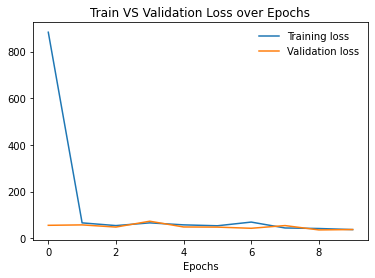

In [ ]:
t = [np.mean(tloss[el]) for el in tloss]
v = [np.mean(vloss[el]) for el in vloss]

plt.plot(t, label='Training loss')
plt.plot(v, label='Validation loss')
plt.title("Train VS Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.legend(frameon=False)